<a href="https://colab.research.google.com/github/neuroqudit/pykoppu/blob/main/notebooks/06_traveling_salesperson.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Traveling Salesperson Problem (TSP) with KOPPU

This notebook demonstrates solving the TSP using the KOPPU OPU. The goal is to find the shortest route visiting each city exactly once and returning to the origin.

## 1. Problem Formulation

Given a set of $N$ cities and distances $d_{ij}$ between them, we want to minimize the total tour length:

$$ L = \sum_{i,j} d_{ij} \sum_{t=1}^{N} x_{i,t} x_{j,t+1} $$

Subject to constraints:
1.  **Each city visited exactly once**: $\sum_{t=1}^{N} x_{i,t} = 1$ for all $i$.
2.  **Each time step has exactly one city**: $\sum_{i=1}^{N} x_{i,t} = 1$ for all $t$.

Where $x_{i,t} \in \{0, 1\}$ is 1 if city $i$ is visited at step $t$.

In [1]:
!pip install pykoppu==0.2.34a0

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 40.9/40.9 kB 2.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.4/2.4 MB 30.4 MB/s eta 0:00:00


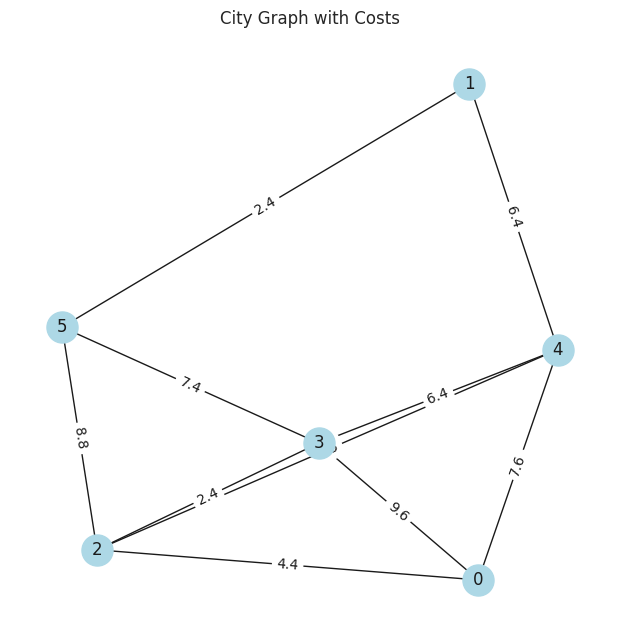

In [6]:
import pykoppu as pk
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt

# 1. Define Graph
n_cities = 6
p_edge = 0.6 # Probability of edge existence
seed = 42
np.random.seed(seed)

# Generate random graph
G = nx.erdos_renyi_graph(n_cities, p_edge, seed=seed)
# Ensure connectivity
while not nx.is_connected(G):
    seed += 1
    G = nx.erdos_renyi_graph(n_cities, p_edge, seed=seed)

# Add random weights
for (u, v) in G.edges():
    G.edges[u,v]['weight'] = np.round(np.random.uniform(1.0, 10.0), 1)

# Calculate Distance Matrix
# If no edge, distance is "infinite" (large value) to discourage usage
large_val = 100.0
dist_matrix = np.full((n_cities, n_cities), large_val)
np.fill_diagonal(dist_matrix, 0)

for u, v, data in G.edges(data=True):
    dist_matrix[u, v] = data['weight']
    dist_matrix[v, u] = data['weight']

# Visualization of the Graph
pos = nx.spring_layout(G, seed=seed)
plt.figure(figsize=(6, 6))
nx.draw(G, pos, with_labels=True, node_color='lightblue', node_size=500)
labels = nx.get_edge_attributes(G, 'weight')
nx.draw_networkx_edge_labels(G, pos, edge_labels=labels)
plt.title("City Graph with Costs")
plt.show()

penalty = 20.0

## 2. PUBO Mapping

We map the constrained optimization to a PUBO by adding penalty terms for the constraints.

The Hamiltonian $H$ is:

$$ H = A \sum_{i} \left(\sum_{t} x_{i,t} - 1\right)^2 + A \sum_{t} \left(\sum_{i} x_{i,t} - 1\right)^2 + \sum_{i,j} d_{ij} \sum_{t} x_{i,t} x_{j,t+1} $$

Where $A$ is the penalty strength.

### Tensors and Solver Process

1.  **Tensors**: The constraints generate inhibitory couplings (penalty for multiple cities at same step or same city at multiple steps) and biases. The distance term generates couplings between variables representing adjacent steps ($t, t+1$).
2.  **Solver Process**: The OPU relaxes to a state that satisfies the constraints (valid tour) while minimizing the distance energy.

Mapping to OPU...
Solving...
Visualizing OPU Dynamics...


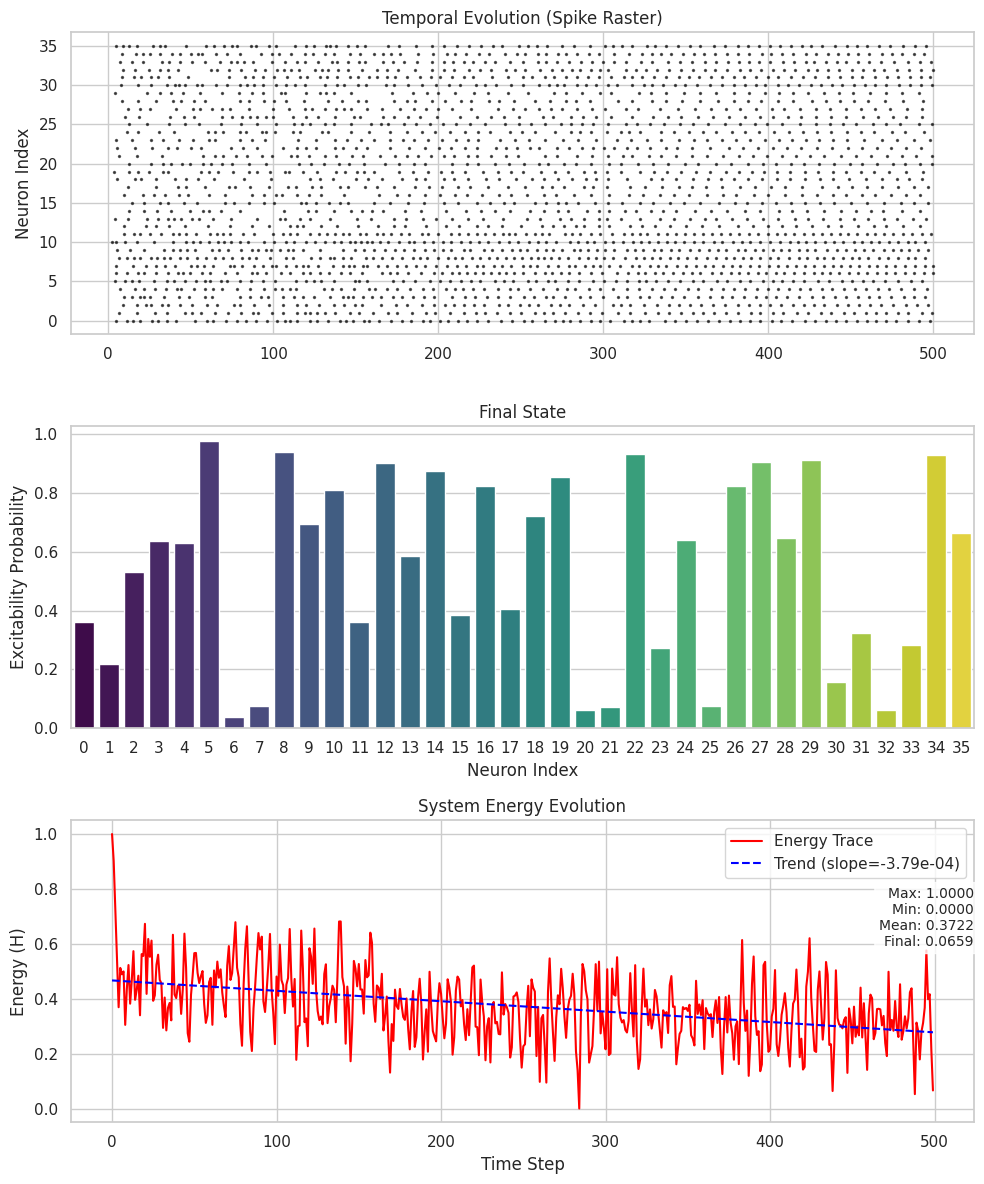

In [8]:
# 2. Create TSP Problem
print("Mapping to OPU...")
problem = pk.problems.logistics.TSP(dist_matrix, penalty)

# 3. Solve
print("Solving...")
process = pk.oos.Process(problem, backend='cpu', t=500)
result = process.run()

# 4. Display OPU Dynamics
print("Visualizing OPU Dynamics...")
result.plot()

## 3. Solution Analysis

We visualize the tour found by the OPU.

Visualizing Tour...


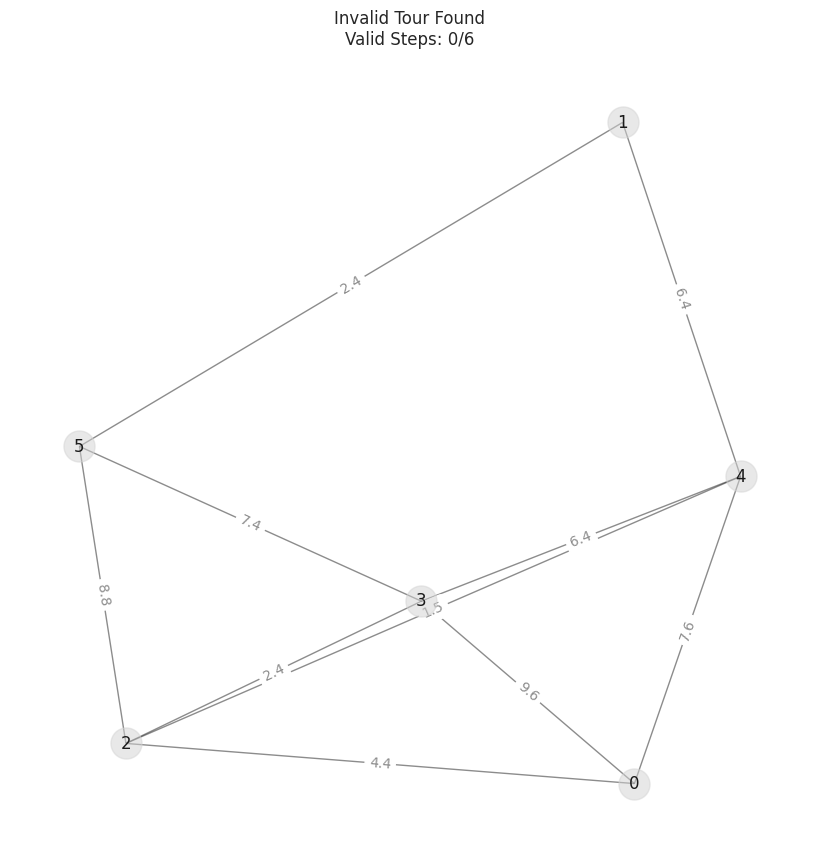

In [9]:
# 5. Analyse Solution
print("Visualizing Tour...")
problem.plot(result, threshold=0.5)